## AutoGen from another angle  

What we've covered so far highlights the high-level usage of AutoGen.  

If you have experience with managing conversations between different large language models (LLMs) and their tools, you'll appreciate how effortlessly AutoGen facilitates these interactions.   

However, simplicity often comes at the cost of flexibility. This is why it's crucial to understand how AutoGen operates under the hood to fully grasp the power of the framework, even if this adds some complexity.  

Here's an overview of the architecture of an AutoGen workflow:  

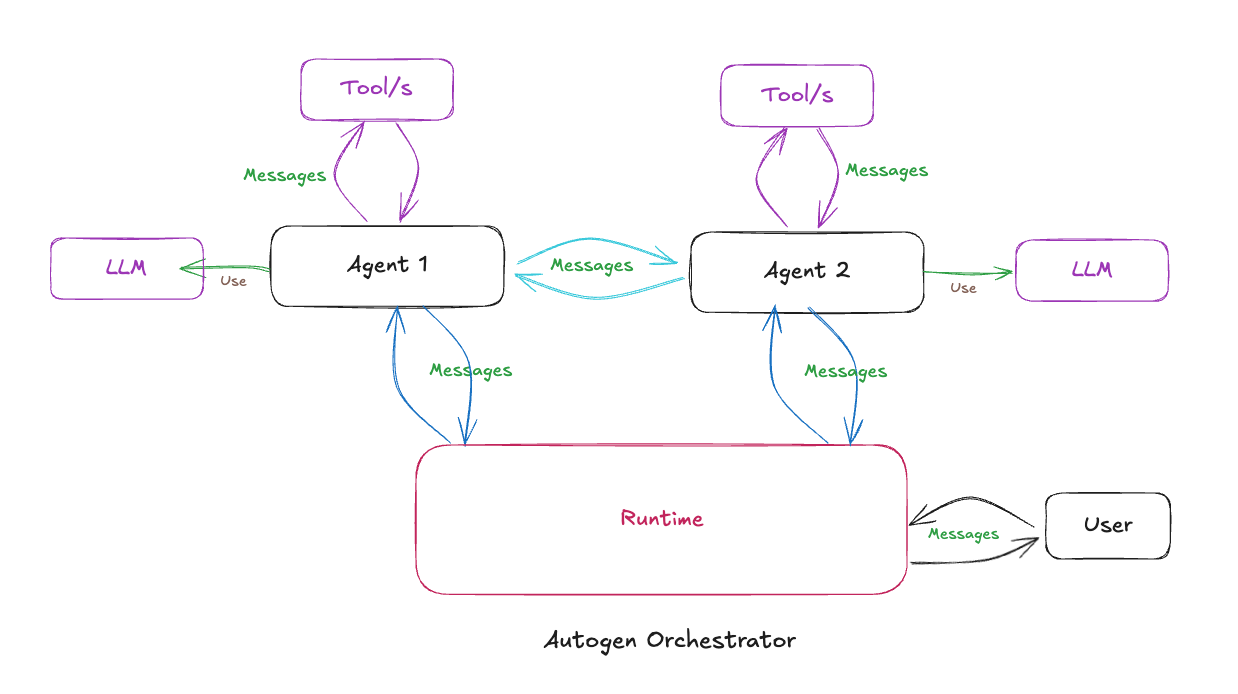  

Starting with the understanding that AutoGen acts as an orchestrator, its operation revolves around the message exchange between various components (agents, tools, etc.). 
The runtime efficiently manages the entire message exchange process.


### Runtime
In Autogen we have two different runtimes:
  
- **Standalone**
  - Suitable for single-process applications where agents are implemented in the same programming language and run in the same process as shown in the picture above.
- **Distributed**
  - A more complex architecture where agents are running in different machine and can potentially be written in different languages

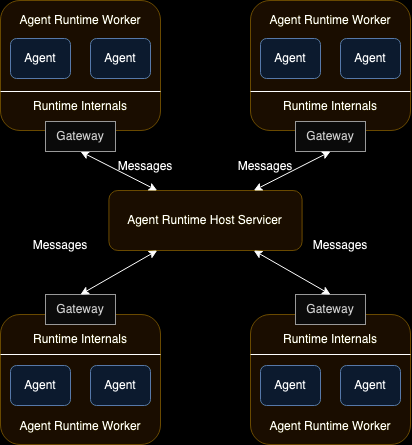  
*Distributed runtime architecture*

### Agent
An agent communicates via **messages**, maintains its own **state**, and **performs actions** in response to received messages or changes in its state. 
These actions may modify the agent’s state and produce external effects, such as updating message logs, sending new messages, executing code, or making API calls. 

Although in most cases an agent uses an LLM to perform its task, its use is not mandatory.

### The Poem -> Reviewer workflow under the hood.

In the [03_teams](03_teams.ipynb) notebook, we saw a workflow in which two agents interacted with each other to produce a poem.
Here is a broad overview of what happens behind the scenes.

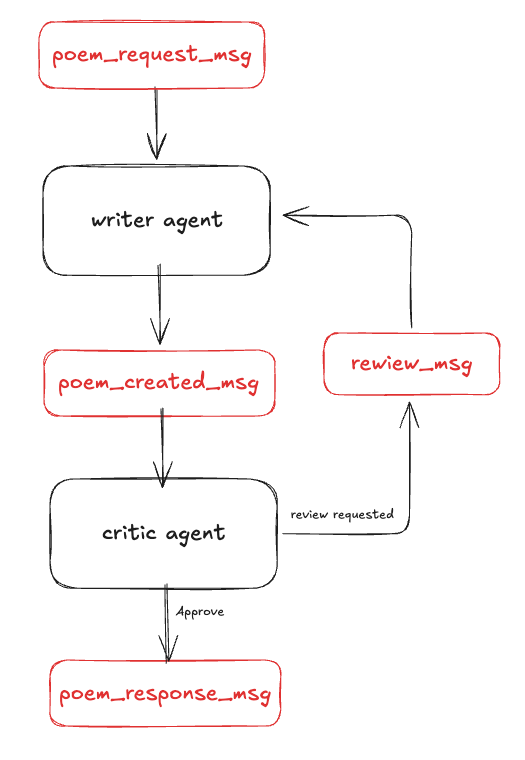

In the picture you can see where each agent receives a message, it processes it, eventually updating its state and it then
produces another message respresenting the result of the incoming message.  

The destination of the output message in this example is clear (another agent or the main application) but there might be cases where the agent just
broadcast a message and, depending on various factors, the receiver might change every time.


## Agent Identity

In multi-agent systems, effective communication requires a robust method to uniquely identify each agent and instantiate them as needed. This is achieved through a structured [Agent ID](https://microsoft.github.io/autogen/stable/user-guide/core-user-guide/core-concepts/agent-identity-and-lifecycle.html#agent-identity-and-lifecycle), comprising two components:

- **Agent Type**: A string that maps to a factory function responsible for creating instances of the agent.
- **Agent Key**: An instance identifier specific to a given agent type.

An agent instance is internally identified using the format: `Agent_Type/Agent_Key`.

*Example*:

Consider an agent type associated with `critic` and identified as "critic_agent". 

Registration in the runtime is performed as follows:

```python
runtime = SingleThreadedAgentRuntime()
await CriticAgent.register(runtime, "critic_agent", lambda: CriticAgent(...)
```

When an agent sends a message to `critic_agent`:

```python
await self.send_message(Message("Here is the poem..."),"critic_agent")
```

The runtime will check if an instance of the `critic_agent` exists, If none exists, it creates one using the registered factory function and then delivers the message to this instance.


**Agent Key Usage:**

By default, each agent instance is assigned the key `default`, resulting in a single instance per Agent_Type.   

For scalability, such as creating distinct instances based on session IDs, the Agent_Key can be specified accordingly:

```python
await self.send_message(Message("Here is the poem..."),"critic_agent/<key>")
```

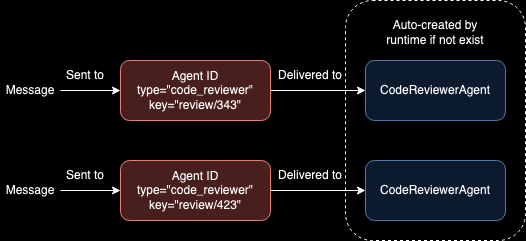

In this scenario, the runtime automatically initiates a new agent instance for each unique session ID.

**Note**:  

*The runtime is also responsible for “paging in” or “out” agent instances to conserve resources and balance load across multiple machines. 
This is not implemented yet.*



